# Swimmer's plot

This notebook generates the "swimmer's plot" for Extended Data Fig. 1a.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.colors as mpcolor
import matplotlib.cm as cm
import palettable
from matplotlib.lines import Line2D
from brokenaxes import brokenaxes

In [2]:
pt_sheet = pd.read_csv('../data/participant_cohort_sheet.tsv', sep = '\t')
sample_sheet = pd.read_csv('../data/sample_cohort_sheet.tsv', sep = '\t')

sample_sheet = sample_sheet[sample_sheet['tumor_normal'] == 'tumor']

print(pt_sheet.shape, sample_sheet.shape)

(181, 48) (342, 27)


# Create clean dataframes

## Samples
Merge samples taken on the same day and mark autopsies

In [3]:
sample_merge_days = 0

sample_data = sample_sheet.sort_values(by = ['participant_id_legacy', 'collection_date_dfd'])
sample_data['group'] = sample_data.groupby('participant_id_legacy', group_keys = False)['collection_date_dfd'].apply(lambda x: x.diff().gt(sample_merge_days).cumsum())
sample_data = sample_data.groupby(['participant_id_legacy', 'group']).agg(
    collection_date_dfd_merged = ('collection_date_dfd', 'min')
).reset_index(level = 1).reset_index()

sample_data = sample_data.merge(pt_sheet[['participant_id_legacy', 'DaysDxtoICB', 'os']], on = 'participant_id_legacy')
sample_data['days_from_ICB_start'] = sample_data['collection_date_dfd_merged'] - sample_data['DaysDxtoICB']

sample_data['sample_type'] = np.where(sample_data['os'] <= sample_data['collection_date_dfd_merged'], 'Autopsy', 'Surgery')

sample_data.head()

,participant_id_legacy,group,collection_date_dfd_merged,DaysDxtoICB,os,days_from_ICB_start,sample_type
0,GBM.ICB-1,0,0.0,1786.0,2915.0,-1786.0,Surgery
1,GBM.ICB-1,1,1884.0,1786.0,2915.0,98.0,Surgery
2,GBM.ICB-1,2,2274.0,1786.0,2915.0,488.0,Surgery
3,GBM.ICB-10,0,23.0,830.0,1228.0,-807.0,Surgery
4,GBM.ICB-10,1,844.0,830.0,1228.0,14.0,Surgery


In [4]:
sample_data['sample_type'].value_counts()

Surgery    277
Autopsy      9
Name: sample_type, dtype: int64

## OS and dx to ICB start date

In [5]:
os_data = pt_sheet[['participant_id_legacy', 'DaysDxtoICB', 'ICB for Newly diagnosed', 'osicb', 'Deceased']]\
    .sort_values(['ICB for Newly diagnosed', 'osicb'],
                ascending = (False, True))
os_data.head()

,participant_id_legacy,DaysDxtoICB,ICB for Newly diagnosed,osicb,Deceased
8,GBM.ICB-109,465.0,Recurrent,69.0,Deceased
152,GBM.ICB-91,438.0,Recurrent,81.0,Deceased
106,GBM.ICB-28,231.0,Recurrent,83.0,Deceased
172,GBM.ICB-419,245.0,Recurrent,85.0,Deceased
25,GBM.ICB-134,1989.0,Recurrent,88.0,Deceased


## ICB treatment

In [6]:
def get_icb_type(row):
    if row['aPD1 ICB'] == 'y' and row['aPDL1 ICB'] == 'y':
        return 'anti-PD-1 ICB and anti-PD-L1 ICB'
    elif row['aPD1 ICB'] == 'y':
        return 'anti-PD-1 ICB'
    elif row['aPDL1 ICB'] == 'y':
        return 'anti-PD-L1 ICB'
    return 'none'

icb_data = pt_sheet[['participant_id_legacy', 'aPD1 ICB', 'aPDL1 ICB', 'DaysDxtoICB', 'DaysDxtoLastICB']].copy()
icb_data['icb_duration'] = icb_data['DaysDxtoLastICB'] - icb_data['DaysDxtoICB']
icb_data['icb_type'] = icb_data.apply(get_icb_type, axis = 1)
icb_data.head()

,participant_id_legacy,aPD1 ICB,aPDL1 ICB,DaysDxtoICB,DaysDxtoLastICB,icb_duration,icb_type
0,GBM.ICB-1,y,n,1786.0,1856.0,70.0,anti-PD-1 ICB
1,GBM.ICB-10,y,n,830.0,932.0,102.0,anti-PD-1 ICB
2,GBM.ICB-102,y,n,307.0,412.0,105.0,anti-PD-1 ICB
3,GBM.ICB-103,n,y,577.0,719.0,142.0,anti-PD-L1 ICB
4,GBM.ICB-104,n,y,625.0,708.0,83.0,anti-PD-L1 ICB


In [7]:
icb_data['icb_type'].value_counts()

anti-PD-1 ICB                       161
anti-PD-L1 ICB                       19
anti-PD-1 ICB and anti-PD-L1 ICB      1
Name: icb_type, dtype: int64

# Formatting setup

In [8]:
pt_pos = dict(zip(os_data['participant_id_legacy'],
                  np.arange(start = 0.25, stop = (os_data['participant_id_legacy'].nunique() + 2) * 0.25, step = 0.25)))

sample_type_mapping = {'Surgery': 'k', 'Autopsy': 'gray'}

icb_type_colors = palettable.scientific.diverging.Roma_5.mpl_colors
icb_type_mapping = {'anti-PD-1 ICB': icb_type_colors[1], 'anti-PD-L1 ICB': icb_type_colors[-1],
                   'anti-PD-1 ICB and anti-PD-L1 ICB': 'sienna'}

diag_colors = palettable.colorbrewer.diverging.PRGn_3.mpl_colors
diag_mapping = {'Newly diagnosed': diag_colors[0], 'Recurrent': diag_colors[2]}

# Create plot

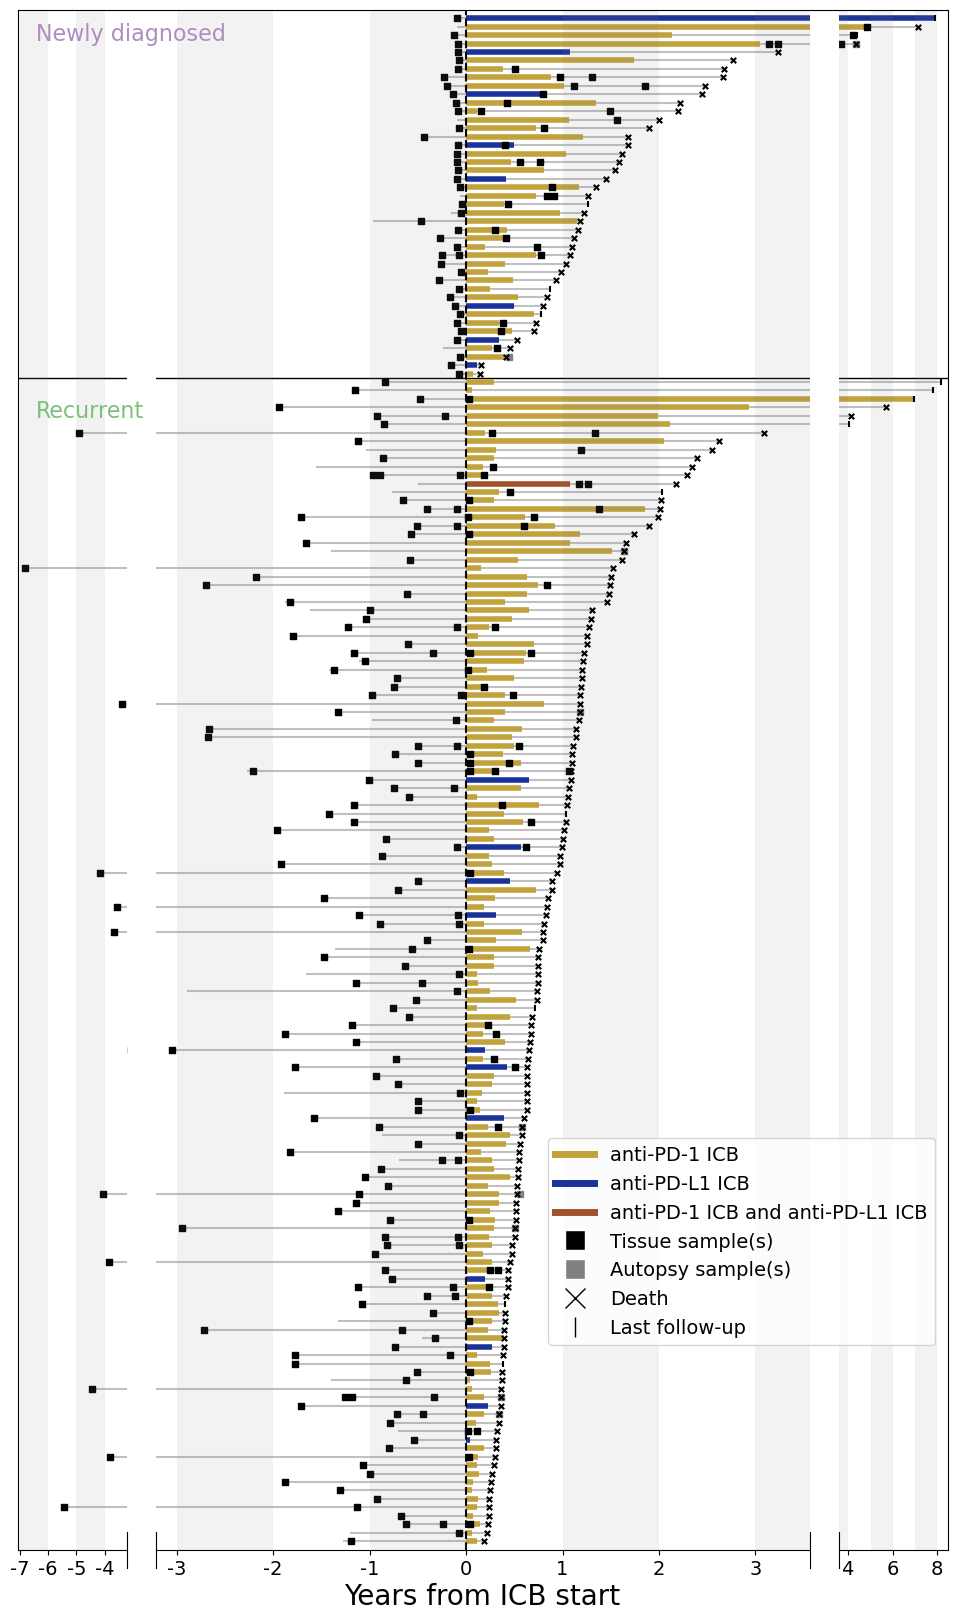

In [9]:
plt.rcParams.update({'font.size': 14})

f = plt.figure(figsize = (12, 20))
ax = brokenaxes(xlims = ((sample_data['days_from_ICB_start'].min() - 100, -1175),
                         (-1175, 1300),
                         (1300, os_data['osicb'].max() + 100)),
               wspace = 0.1,
               width_ratios = [1,6,1],
               tilt = 90)

# Plot treatments
for i, row in icb_data.iterrows():
    y_pos = pt_pos[row['participant_id_legacy']]
    ax.hlines(y_pos,
              0,
              row['icb_duration'],
              colors = icb_type_mapping[row['icb_type']],
              linewidths = 4,
              zorder = -1,
              label = row['icb_type'])
    
# Plot samples
for i, row in sample_data.iterrows():
    y_pos = pt_pos[row['participant_id_legacy']]
    ax.scatter(row['days_from_ICB_start'],
              y_pos,
              marker = 's',
              c = sample_type_mapping[row['sample_type']],
              s = 15,
              zorder = 1,
              label = 'Sample')
    
# Plot OS + vital status and disease course (dx to death/last follow-up)
for i, row in os_data.iterrows():
    y_pos = pt_pos[row['participant_id_legacy']]
    if row['Deceased'] == 'Deceased':
        ax.scatter(row['osicb'],
           y_pos,
           marker = 'x',
           c = 'k',
           s = 15,
           zorder = 2,
           label = 'Deceased')
    elif row['Deceased'] == 'Alive':
        ax.scatter(row['osicb'],
           y_pos,
           marker = '|',
           c = 'k',
           s = 15,
           zorder = 2,
           label = 'Alive')
    ax.hlines(y_pos,
              -row['DaysDxtoICB'],
              row['osicb'],
              colors = 'silver',
              linewidths = 1.5,
              zorder = -2)
    
# Line at ICB start
ax.vlines(0, 0, max(pt_pos.values()) + 0.25, color = 'k', linestyles = '--', zorder = -1)
ax.set_ylim((0, max(pt_pos.values()) + 0.25))
    
# Distinguish newly diagnosed and recurrent pts
border = pt_pos[os_data.loc[os_data[os_data['ICB for Newly diagnosed'] == 'Newly-diagnosed']['osicb'].idxmin(), 'participant_id_legacy']] - 0.125
ax.hlines(border,
          -1e4,
          1e4,
          colors = 'black',
          linewidths = 1,
          zorder = -2)

ax.axs[0].set_yticks([])

plt.text(0.02, 0.98, 'Newly diagnosed', size = 16, color = diag_mapping['Newly diagnosed'])
plt.text(0.02, 0.735, 'Recurrent', size = 16, color = diag_mapping['Recurrent'])

# Labels
m = 365

x_ticks_0 = list(range(-7*m, -3*m, m))
x_ticks_0_label=np.array(x_ticks_0)/m
ax.axs[0].set_xticks(x_ticks_0)
ax.axs[0].set_xticklabels(x_ticks_0_label.astype(int), fontsize=14)

x_ticks_1 = list(range(-3*m, 4*m, m))
x_ticks_1_label=np.array(x_ticks_1)/m
ax.axs[1].set_xticks(x_ticks_1)
ax.axs[1].set_xticklabels(x_ticks_1_label.astype(int), fontsize=14)

x_ticks_2 = list(range(4*m, 9*m, 2*m))
x_ticks_2_label=np.array(x_ticks_2)/m
ax.axs[2].set_xticks(x_ticks_2)
ax.axs[2].set_xticklabels(x_ticks_2_label.astype(int), fontsize=14)

ax.big_ax.set_xlabel('Years from ICB start', fontsize=20, labelpad=24)

# Plot shading for every other year
counter=0
for i in range(-8*m, -4*m, m):
    counter=counter+1

    if counter % 2 == 1: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(pt_pos.values()) + 0.25, ec='none',color='gray', alpha=0.1)
    ax.axs[0].add_patch(newpatch)

counter=0
for i in range(-3*m, 4*m, m):
    counter=counter+1

    if counter % 2 == 0: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(pt_pos.values()) + 0.25, ec='none',color='gray', alpha=0.1)
    ax.axs[1].add_patch(newpatch)

counter=0
for i in range(3*m, 9*m, m):
    counter=counter+1

    if counter % 2 == 0: continue

    newpatch=mpatches.Rectangle([i, 0], m, max(pt_pos.values()) + 0.25, ec='none',color='gray', alpha=0.1)
    ax.axs[2].add_patch(newpatch)

# Add treatments to legend
legend_elements = []
for tx in icb_type_mapping:
    new_legend = Line2D([0], [0], color = icb_type_mapping[tx], lw = 5, label = tx)
    legend_elements.append(new_legend)

# Add samples to legend
legend_elements.append(Line2D([0], [0], marker = 's', color = 'w', label = 'Tissue sample(s)', markerfacecolor = sample_type_mapping['Surgery'], markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 's', color = 'w', label = 'Autopsy sample(s)', markerfacecolor = sample_type_mapping['Autopsy'], markersize = 15))
legend_elements.append(Line2D([0], [0], marker = 'x', label = 'Death', ls = 'None', markeredgecolor = 'k', markersize = 15))
legend_elements.append(Line2D([0], [0], marker = '|', label = 'Last follow-up', ls = 'None', markeredgecolor = 'k', markersize = 15))

ax.big_ax.legend(handles = legend_elements, bbox_to_anchor = (0.57, 0.2), loc = 'center left', borderaxespad = 0)

ax.big_ax.spines[['right', 'top']].set_visible(True)
